#### 1) Anomaly(top 25%) of WT4, DJF (Wet California) (ECMWF)
 - 1.1) Find the top 25% of years that have the highest frequency of WT4 in DJF
 - 1.2) Calculate the seasonal mean Z500 for those top 25% of years.
 - 1.3) Calculate the seasonal mean/STD over all years. 
 - 1.4) Plot the anomaly of the top 25% of years (P75-climatoloty)/stddev(climatoloty) 

#### 2) Anomaly of WT9 JAS (Wet Monson) 
 - 2.1) Find the top 25% of years that have the highest frequency of WT9 in ASO
 - 2.2) Calculate the seasonal mean Z500 for those top 25% of years.
 - 2.3) Calculate the seasonal mean/STD over all years. 
 - 2.4) Plot the anomaly of the top 25% of years (P75-climatoloty)/stddev(climatoloty) 

#### 3) 500 hPa 12Z weather types anomaly seasonal maps

In [26]:
import sys
import datetime
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import xarray as xr
import cfgrib
import matplotlib.pyplot as plt
import glob 
import os.path
import cartopy 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# inorder to import my pathon module, add
# $PYTHONPATH for jupyter for module
sys.path.append("/glade/u/home/mingge/PYTHON")
import coexist_func 
from importlib import reload
reload(coexist_func)
from coexist_func import plot_single
from coexist_func import find_year_top25_wt_ecmwf
from coexist_func import find_year_top25_wt_en_ecmwf
from coexist_func import cal_seasonalmean_wt_qspd850_ecmwf
from coexist_func import cal_season_std_qspd850_ecmwf
from coexist_func import ax_coastlines_country
from coexist_func import cal_season_cli_qspd850_ecmwf
from coexist_func import cal_season_ano_qspd850_ecmwf
from coexist_func import plot_prec_12

casper_2020

#### setups

In [27]:
dir_ecmwf = '/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/QV850/'
dir_wt = '/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/WT_01/'

season_dict = {
    'DJF': [12,1,2],
    'MAM': [3,4,5],
    'JJA': [6,7,8],
    'SON': [9,10,11],
    'JAS': [7,8,9]}

n_season = len(season_dict)

year_s = 1993
year_e = 2021
n_year = year_e - year_s + 1

n_wt = 12

### check on data

In [28]:
# step: 215, latitude: 101, longitude: 360)
flnm_test = dir_ecmwf + 'qspd850_201702.nc'
ds = xr.load_dataset(flnm_test)
print('dataset', ds)
latitude = ds.latitude
longitude = ds.longitude    # -180-180

print(ds.dims)
n_step = ds.dims['step']
n_lat  = ds.dims['latitude']
n_lon  = ds.dims['longitude'] 

dataset <xarray.Dataset>
Dimensions:        (number: 51, step: 430, latitude: 101, longitude: 360)
Coordinates:
  * number         (number) int64 0 1 2 3 4 5 6 7 8 ... 43 44 45 46 47 48 49 50
    time           datetime64[ns] 2017-02-01
  * step           (step) timedelta64[ns] 0 days 12:00:00 ... 215 days 00:00:00
    isobaricInhPa  int64 700
  * latitude       (latitude) float64 80.0 79.0 78.0 77.0 ... -18.0 -19.0 -20.0
  * longitude      (longitude) float64 -180.0 -179.0 -178.0 ... 178.0 179.0
    valid_time     (step) datetime64[ns] 2017-02-01T12:00:00 ... 2017-09-04
Data variables:
    qspd850        (number, step, latitude, longitude) float32 0.003599 ... 0...
Frozen({'number': 51, 'step': 430, 'latitude': 101, 'longitude': 360})


#### calculate qspd

In [29]:
dir_ec = '/glade/scratch/mingge/ECMWF/'
for year in range(year_s, year_e+1, 1):
    #print(year)
    for month in range(1,13,1):
        yyyymm_s = str(year*100 + month)
        
        flnm_o = dir_ecmwf + 'qspd850_' + yyyymm_s + '.nc' 
        
        if not os.path.isfile(flnm_o):
            #mon_s = str(month).zfill(2)
            flnm_q = dir_ec + yyyymm_s + '/Q850_GDS0_ISBL/q850_' + yyyymm_s + '.grib'
            flnm_u = dir_ec + yyyymm_s + '/U850_GDS0_ISBL/u850_' + yyyymm_s + '.grib' 
            flnm_v = dir_ec + yyyymm_s + '/V850_GDS0_ISBL/v850_' + yyyymm_s + '.grib' 
            print(flnm_q)
            with xr.open_dataset(flnm_q, engine="cfgrib") as ds_q:
                q = ds_q.q
                
            print(flnm_u)
            with xr.open_dataset(flnm_u, engine="cfgrib", backend_kwargs={'indexpath' :'' }) as ds_u:
                u = ds_u.u
                
            print(flnm_v)
            with xr.open_dataset(flnm_v, engine="cfgrib", backend_kwargs={'indexpath' :'' }) as ds_v:
                v = ds_v.v
        
            qspd = (q*(u*u + v*v)**(1/2)).rename('qspd850')
                
            print(flnm_o)
            qspd.to_netcdf(flnm_o) 
             

#### 1.1) Find the top 25% of years that have the highest frequency of  WT4 in DJF

In [30]:
# for winter DJF season_dict[1]
key = 'DJF'

# target WT 4
wt_t = 4

# I test Count 25 member as a whole and then each member, they get similar results
# Count 25 member as a whole
year_p75 = find_year_top25_wt_ecmwf(year_s, year_e, season_dict, dir_ecmwf, dir_wt, wt_t, key) 

# count each member
# year_p75_2d = find_year_top25_wt_en_ecmwf(year_s, year_e, season_dict, dir_ecmwf, dir_wt, wt_t, key) 

member 1 -  25
        z500
1993   577.0
2011   988.0
2006  1057.0
2009  1077.0
2008  1133.0
2020  1173.0
1996  1195.0
1999  1199.0
2021  1203.0
2001  1215.0
2007  1223.0
2012  1265.0
2013  1280.0
2019  1296.0
2002  1298.0
1994  1302.0
1998  1315.0
2017  1328.0
1997  1330.0
2000  1337.0
2010  1372.0
2004  1388.0
2014  1395.0
1995  1399.0
2018  1411.0
2005  1425.0
2003  1452.0
2016  1504.0
2015  1598.0
top 25% years are Int64Index([2014, 1995, 2018, 2005, 2003, 2016, 2015], dtype='int64')


 - 1.2) Calculate the seasonal mean Qdiv850 for those top 25% of years.

In [31]:
flnm_o = dir_ecmwf + 'qspd850_p75_wt' + str(wt_t) + '_'+ key +'.nc'
qdiv850_p75_2d_xr = cal_seasonalmean_wt_qspd850_ecmwf('qspd850', dir_ecmwf, season_dict, key, year_p75, latitude, longitude, flnm_o)

/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/QV850/qspd850_p75_wt4_DJF.nc exist
mean of member 1-25 
Frozen({'latitude': 101, 'longitude': 360})


- 1.3) read the seasonal mean and STD over all years

In [20]:
flnm_o = dir_ecmwf + 'qspd850_'+ key +'_MeanStd.nc'
var_cli_xr = cal_season_std_qspd850_ecmwf('qspd850', dir_ecmwf, season_dict, key, year_s, year_e, latitude, longitude, flnm_o)
var_xr = var_cli_xr[0]
var_std_xr= var_cli_xr[1]

/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/QV850/qspd850_DJF_MeanStd.nc exist
Frozen({'mean_std': 2, 'latitude': 101, 'longitude': 360})


 - 1.4) Plot the anomaly of the top 25% of years (P75-climatoloty)/stddev(climatoloty) 

/glade/work/mingge/miniconda3/envs/casper_2020/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'vcenter'
  result = super().contourf(*args, **kwargs)


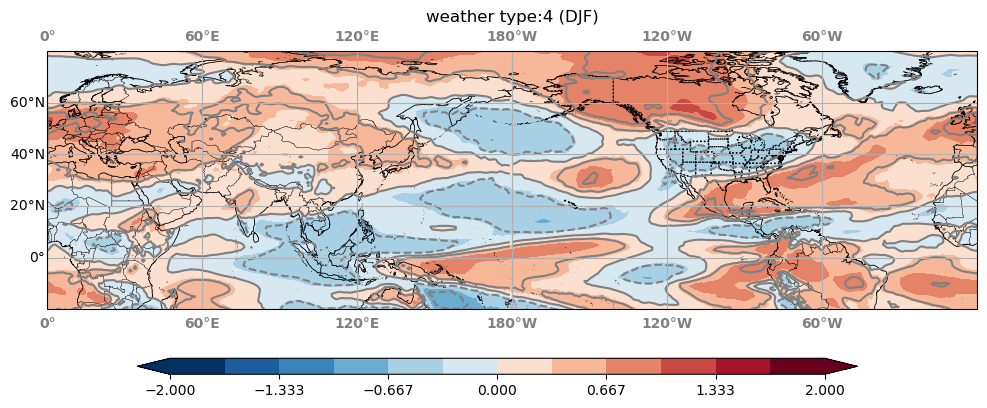

In [21]:
ano_2d = (qdiv850_p75_2d_xr - var_xr)/var_std_xr
plot_single(ano_2d, wt_t, key, -2, 2, 13)

#### 2) WT9 (wet monsoon) for JAS.
 - 2.1) Find the top 25% of years that have the highest frequency of WT9 in JAS

In [22]:
# for winter DJF season_dict[1]
key = 'JAS'

# target WT 9
wt_t = 9

year_p75 = find_year_top25_wt_ecmwf(year_s, year_e, season_dict, dir_ecmwf, dir_wt, wt_t, key)  

member 1 -  25
        z500
2010  4466.0
2011  4625.0
2008  4953.0
2005  4954.0
2012  5069.0
1998  5070.0
2006  5259.0
2007  5283.0
2004  5357.0
2020  5434.0
1999  5447.0
1995  5533.0
2000  5581.0
2016  5606.0
2013  5619.0
2002  5650.0
1996  5686.0
2003  5733.0
2017  5866.0
2014  5870.0
2021  5893.0
1993  5912.0
2001  5935.0
2015  5939.0
2019  6091.0
1997  6108.0
1994  6151.0
2018  6172.0
2009  6262.0
top 25% years are Int64Index([2001, 2015, 2019, 1997, 1994, 2018, 2009], dtype='int64')


 - 2.2) Calculate the seasonal mean Z50 for those top 25% of years.

In [23]:
## similar pattern with SMYLY ERAI, but half maximum

flnm_o = dir_ecmwf + 'qspd850_p75_wt' + str(wt_t) + '_'+ key +'.nc'
z500_p75_2d_xr = cal_seasonalmean_wt_qspd850_ecmwf('qspd850',dir_ecmwf, season_dict, key, year_p75, latitude, longitude, flnm_o)

/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/QV850/qspd850_p75_wt9_JAS.nc exist
mean of member 1-25 
Frozen({'latitude': 101, 'longitude': 360})


 - 2.3)  read the seasonal mean and STD over all years

In [24]:
flnm_o = dir_ecmwf + 'qspd850_'+ key +'_MeanStd.nc'
var_cli_xr = cal_season_std_qspd850_ecmwf('qspd850', dir_ecmwf, season_dict, key, year_s, year_e, latitude, longitude, flnm_o)
var_xr = var_cli_xr[0]
var_std_xr= var_cli_xr[1]

/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/QV850/qspd850_JAS_MeanStd.nc exist
Frozen({'mean_std': 2, 'latitude': 101, 'longitude': 360})


 - 2.4) Plot the anomaly of the top 25% of years (P75-climatoloty)/stddev(climatoloty)

/glade/work/mingge/miniconda3/envs/casper_2020/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'vcenter'
  result = super().contourf(*args, **kwargs)


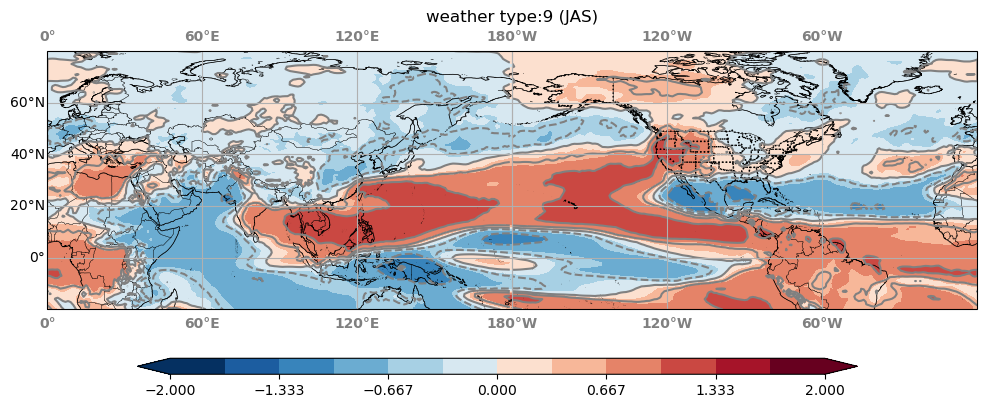

In [25]:
ano_2d = (z500_p75_2d_xr - var_xr)/var_std_xr
plot_single(ano_2d, wt_t, key, -2, 2, 13)

#### 3) Qspd 850 hPa 12Z anomaly seasonal maps for WTs (25 members)

In [32]:
flnm_cli = dir_ecmwf + 'qspd850_seasonal_cli.nc'
z500_cli_xr = cal_season_cli_qspd850_ecmwf('qspd850', dir_ecmwf, season_dict, year_s, year_e, latitude, longitude, flnm_cli) 

/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/QV850/qspd850_seasonal_cli.nc exist


In [33]:
### check cal_season_ano_qspd850_ecmwf n_mem
flnm_ano = dir_wt + 'qspd850_seasonal_ano.nc'
z500_wt = cal_season_ano_qspd850_ecmwf('qspd850', dir_ecmwf, dir_wt, season_dict, year_s, year_e, latitude, longitude, flnm_cli, flnm_ano)

/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/WT_01/qspd850_seasonal_ano.nc exist


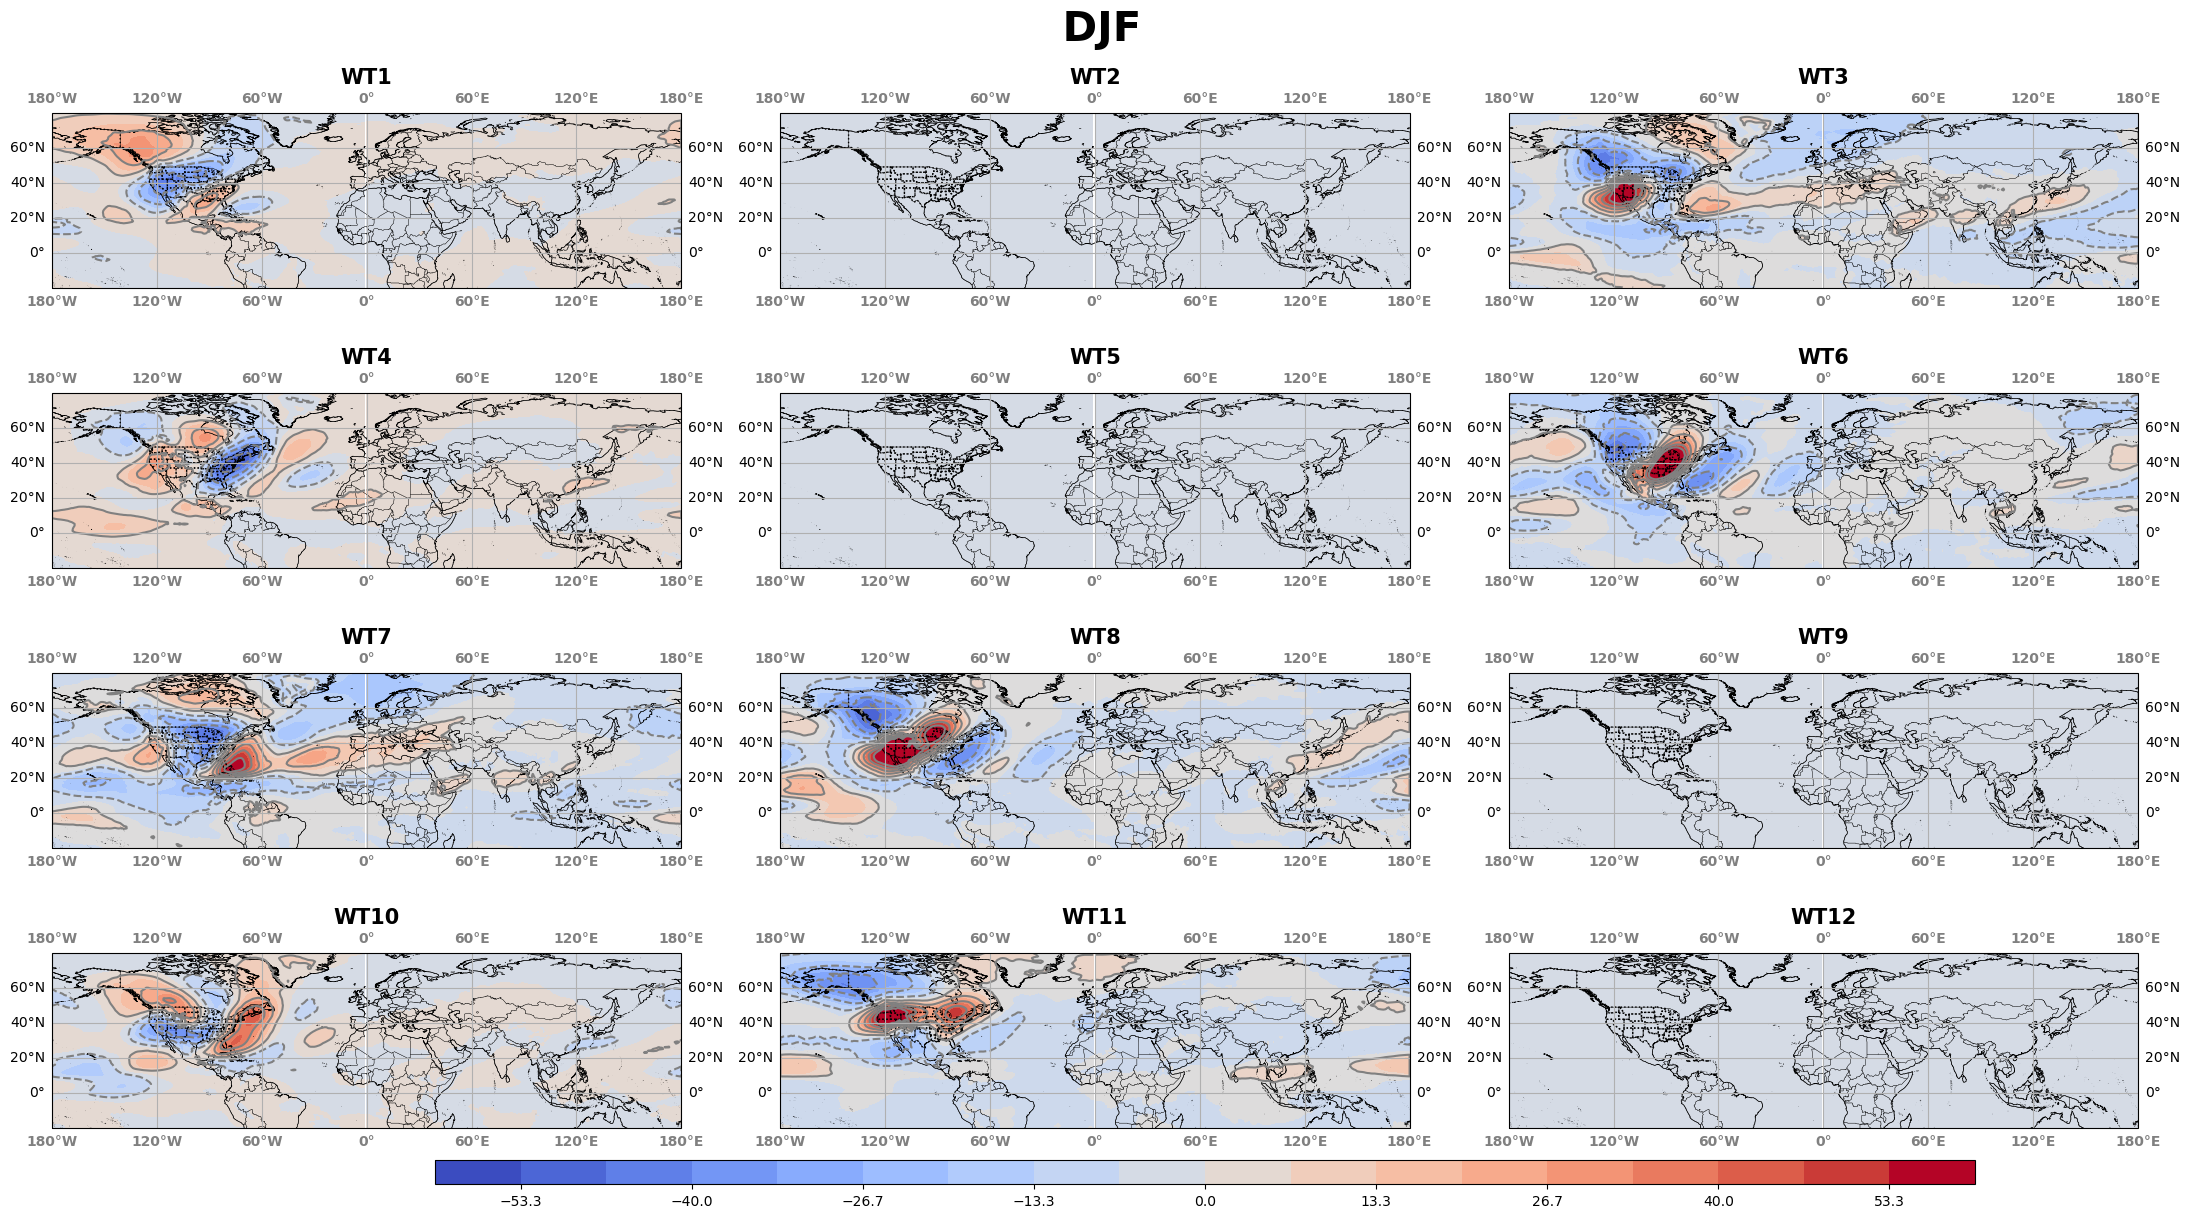

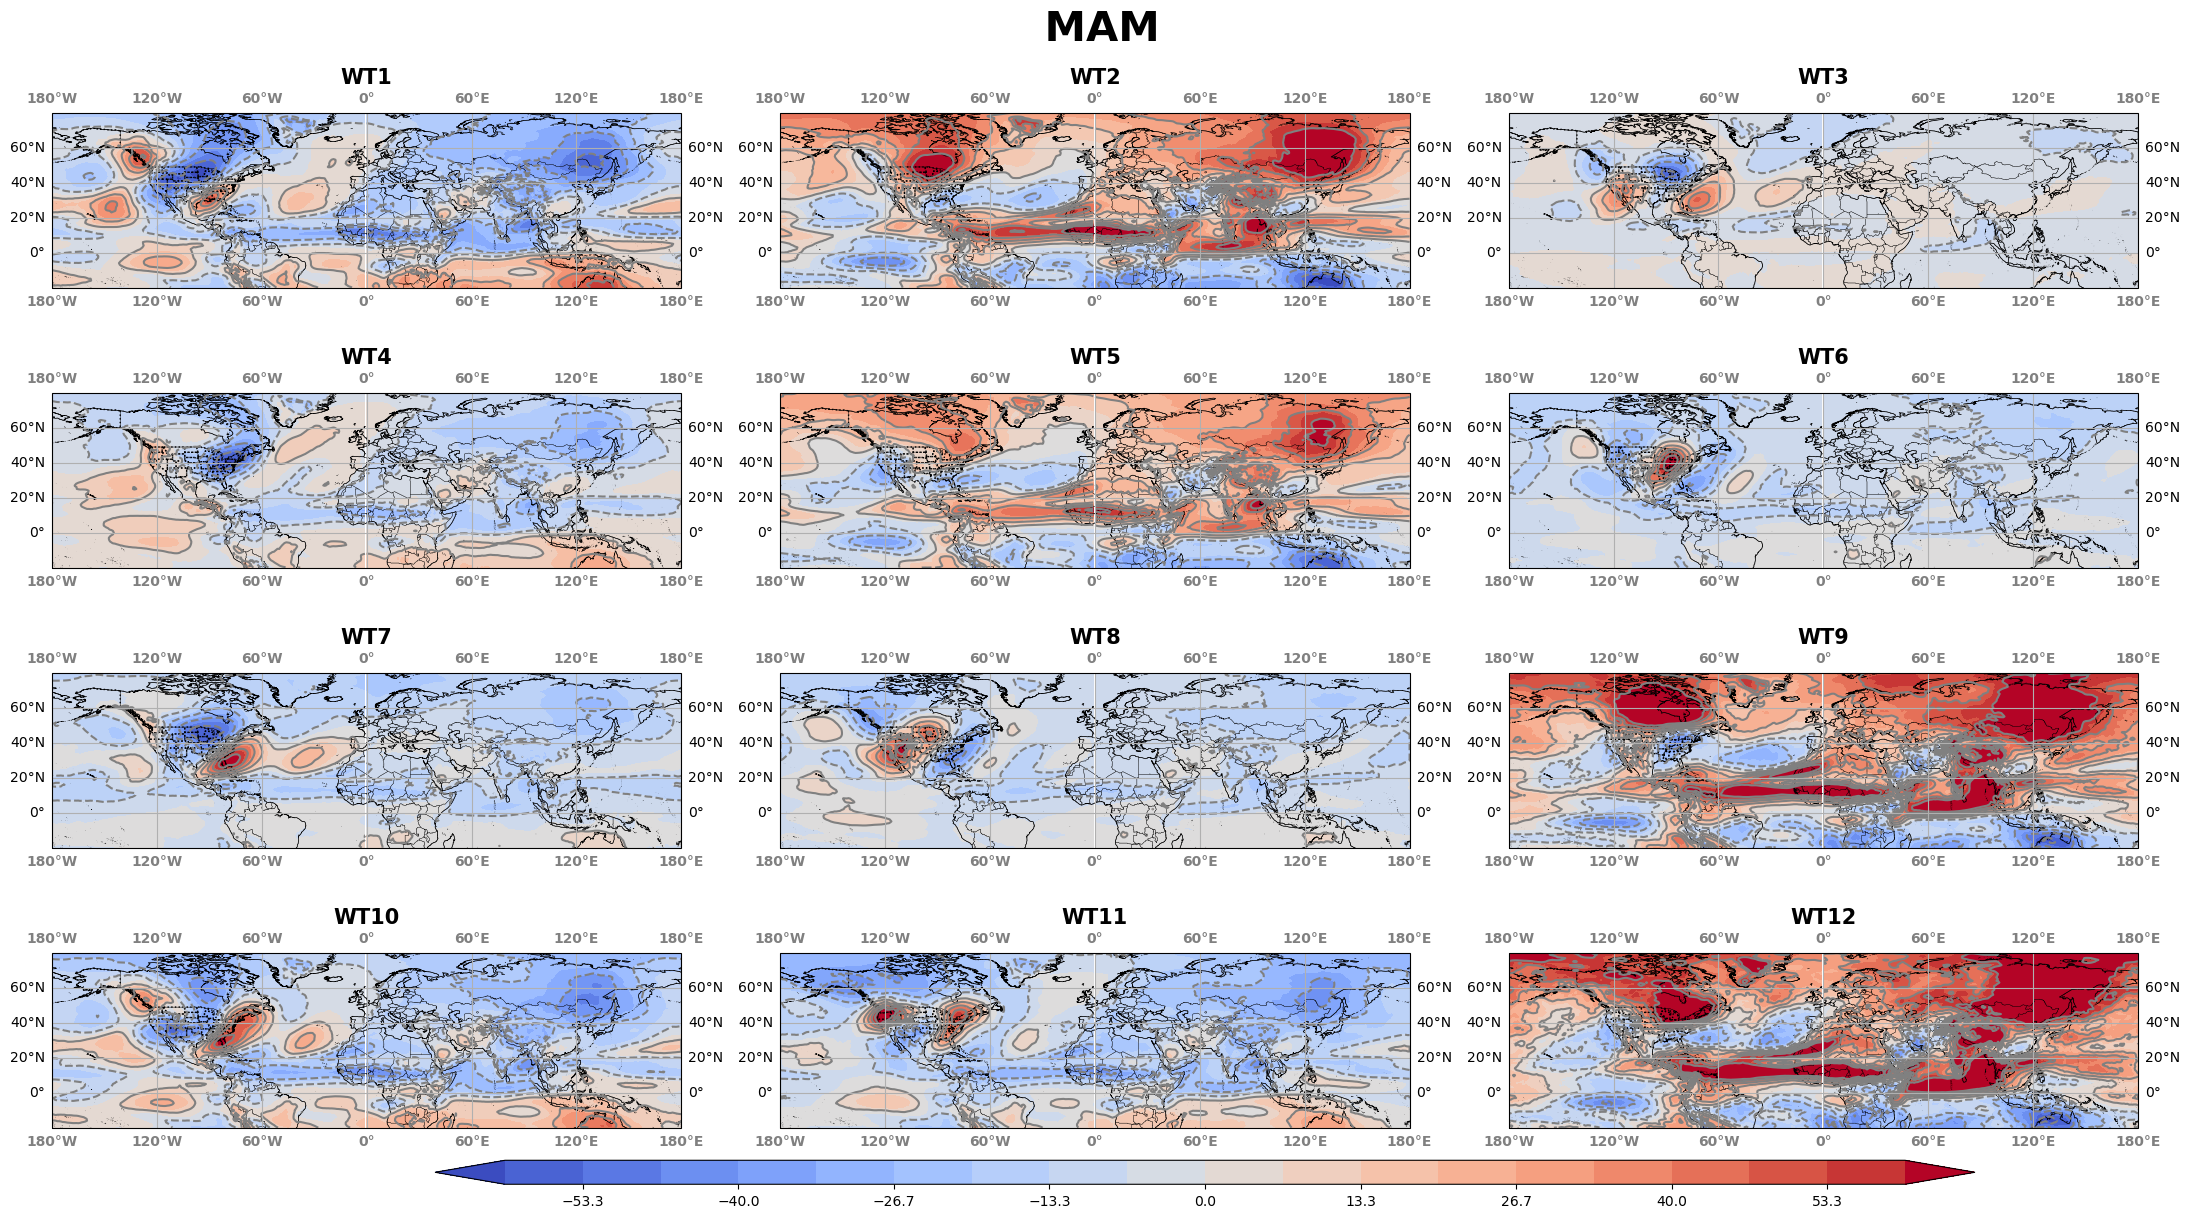

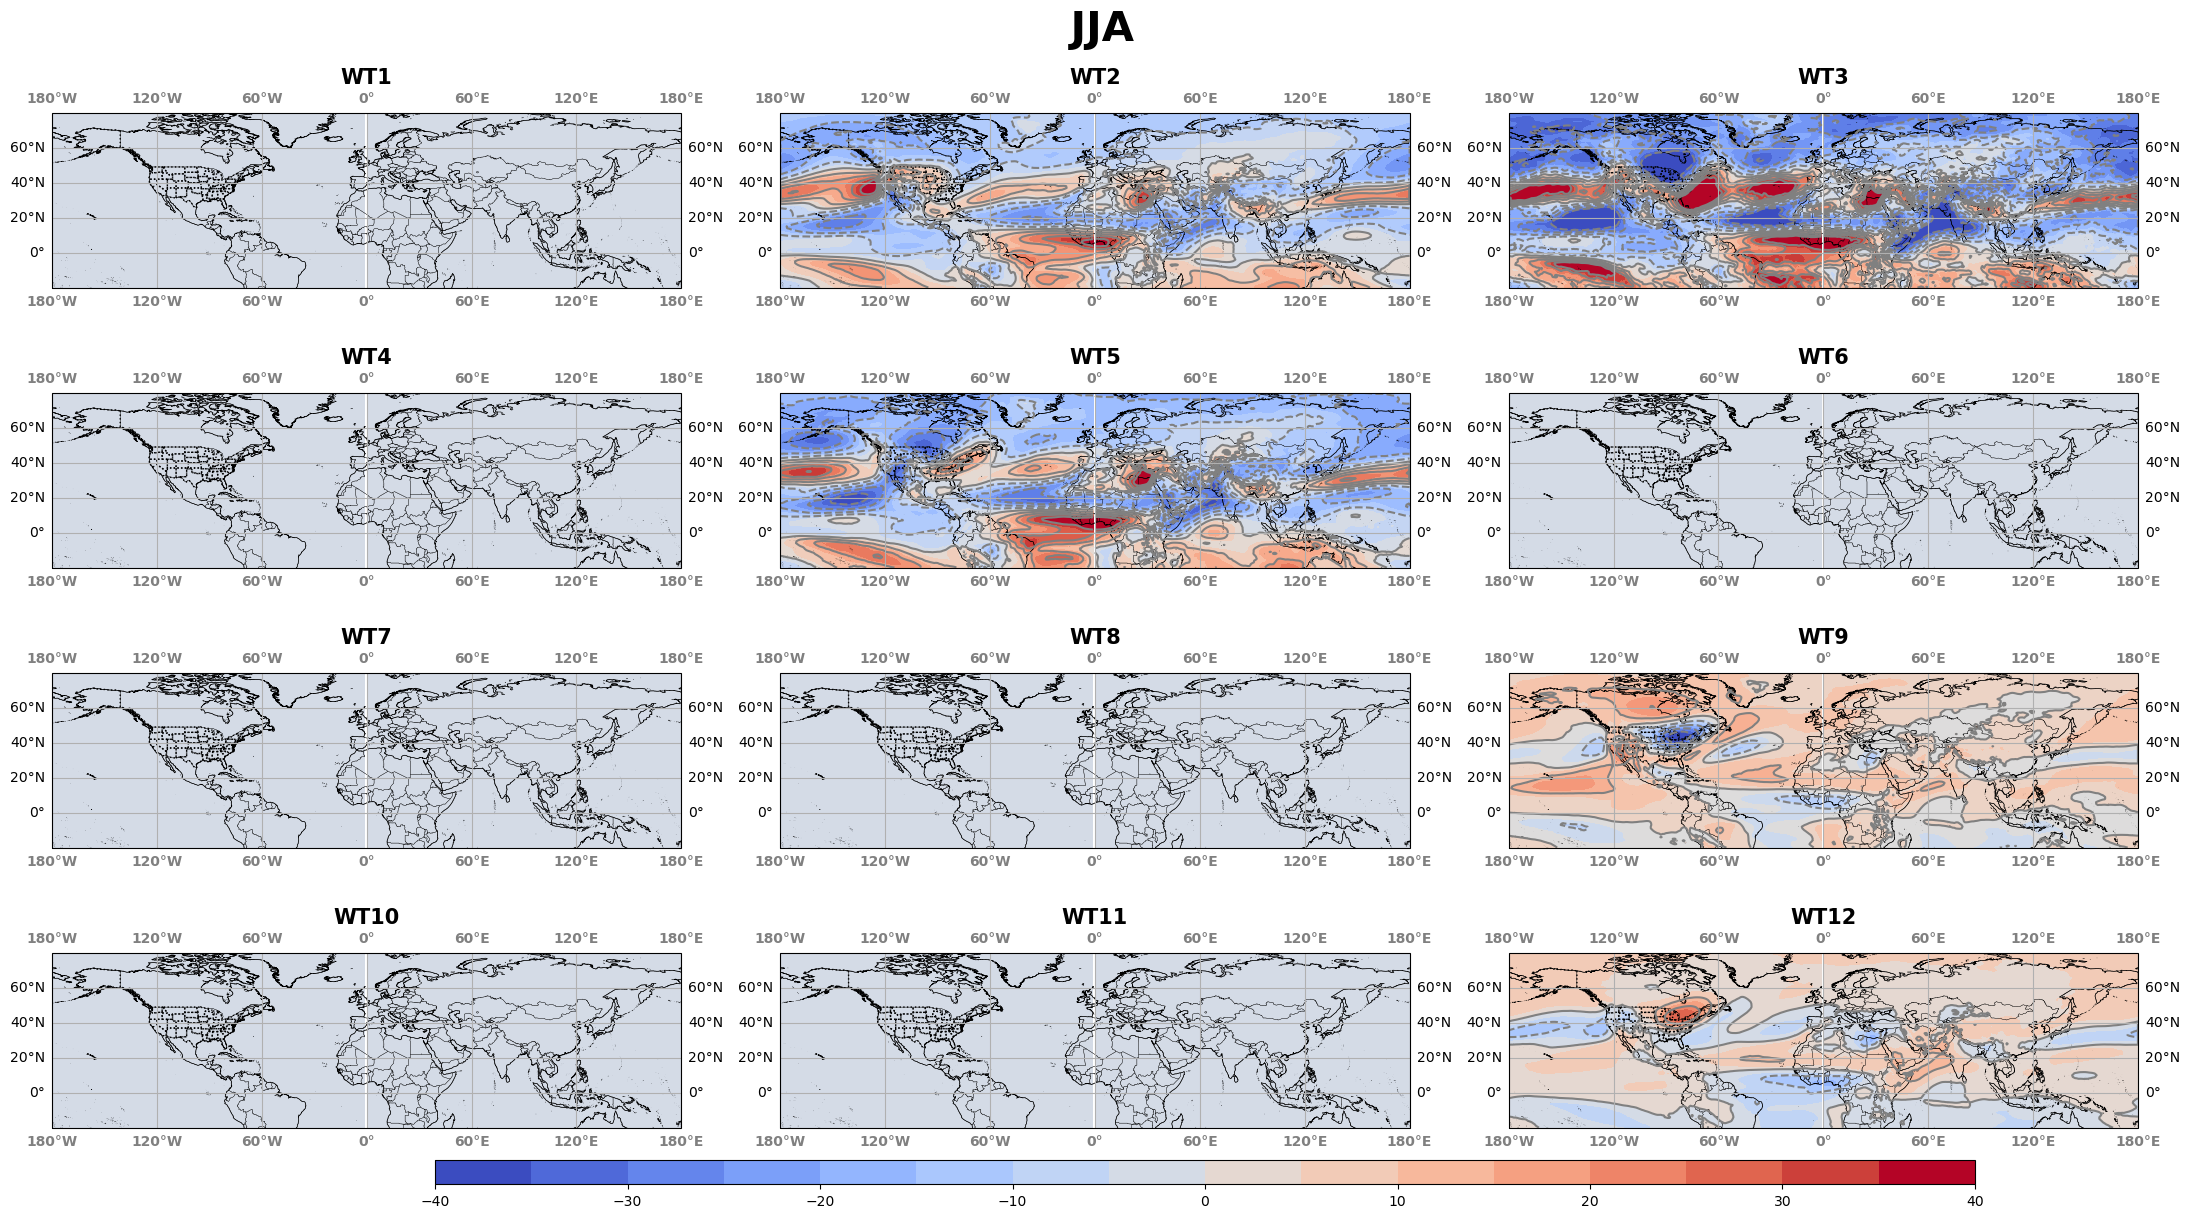

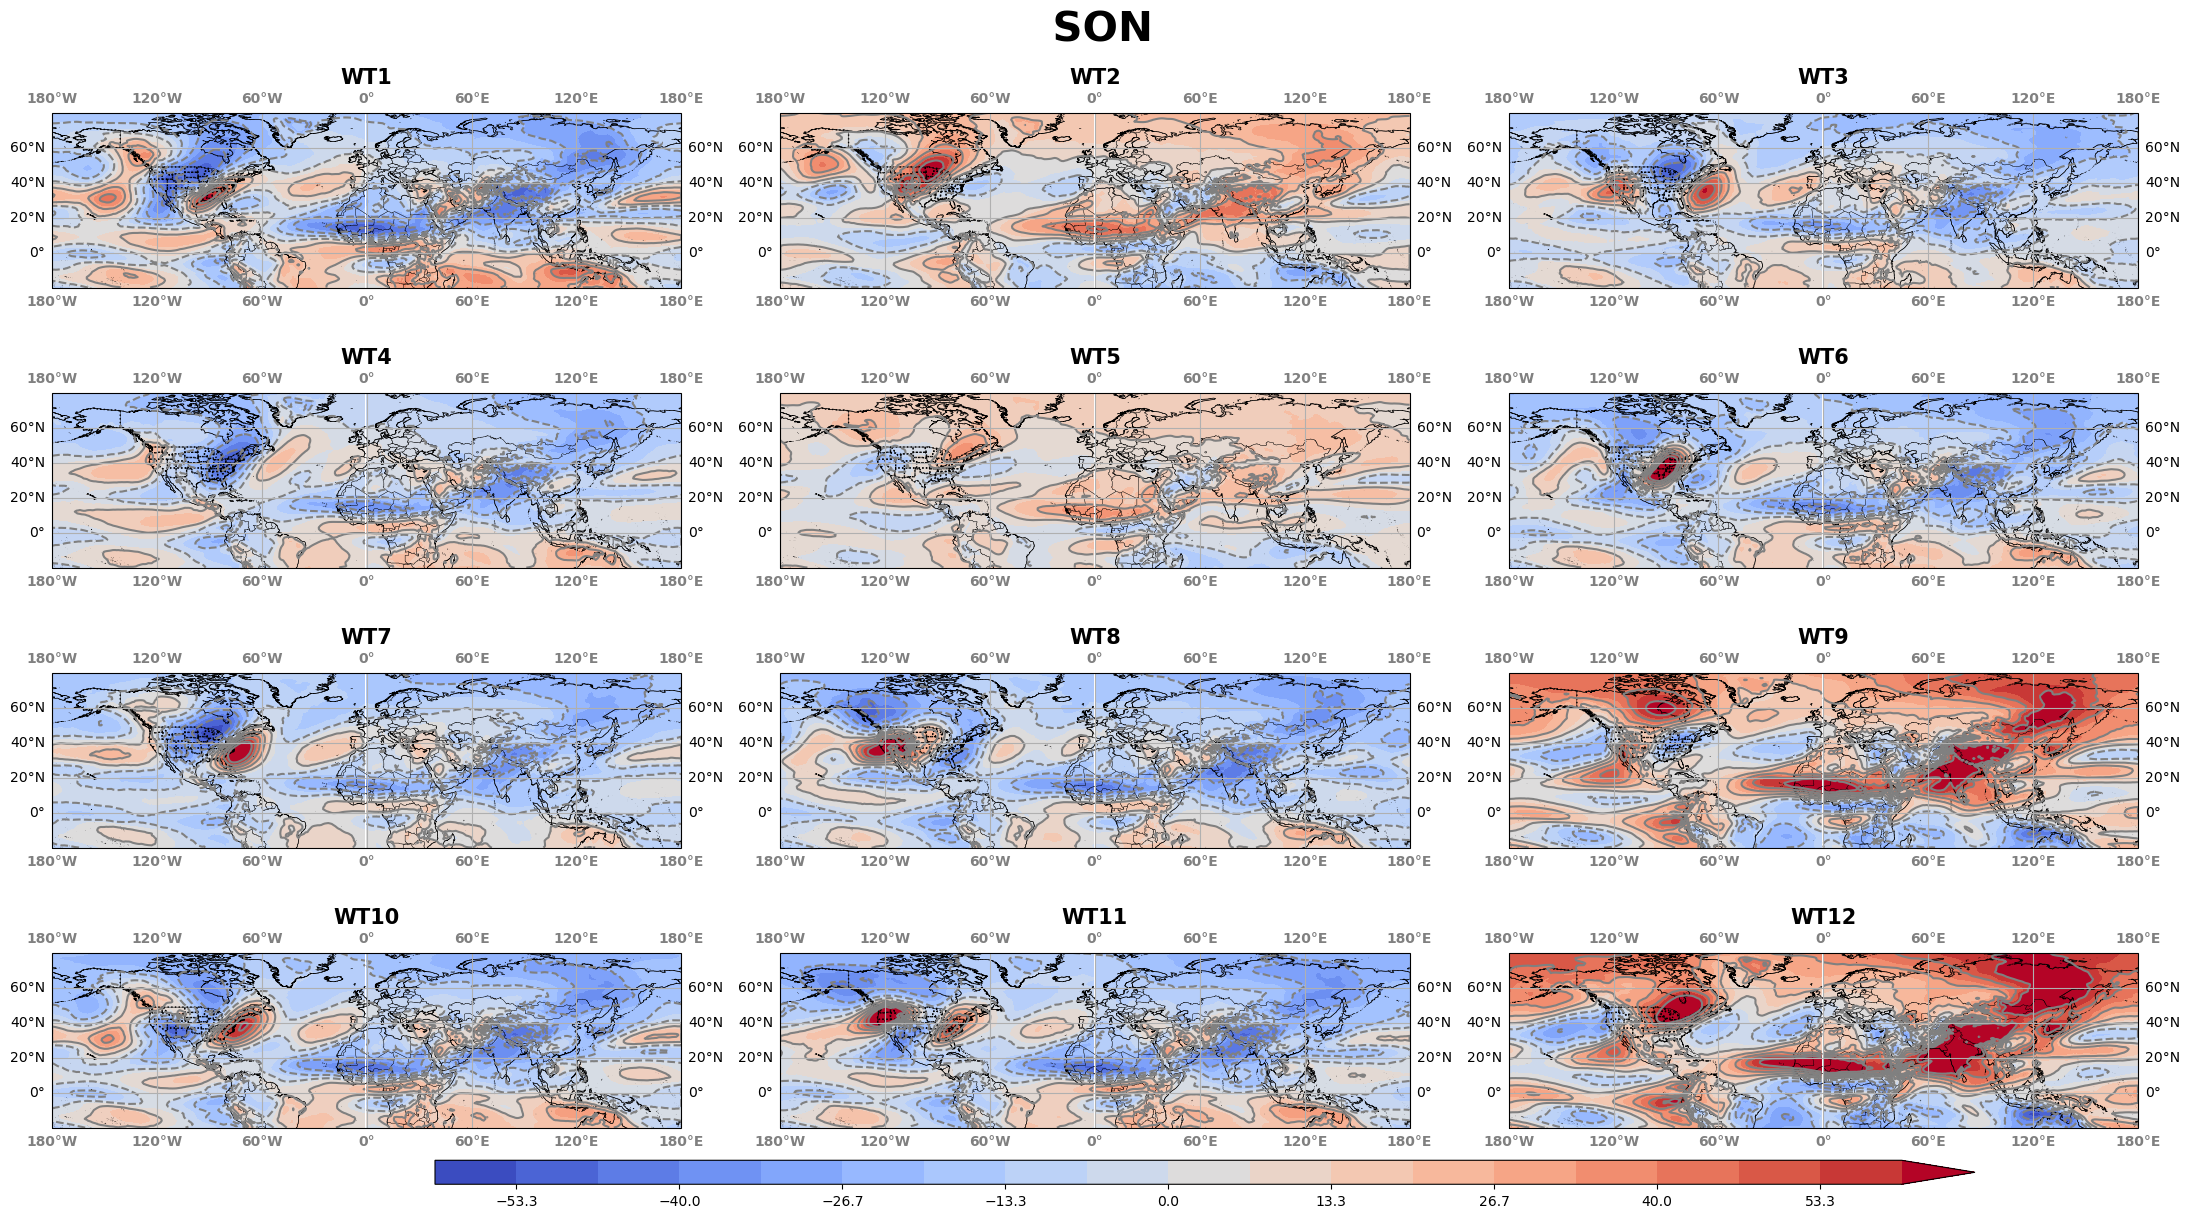

In [16]:
season_s = ['DJF','MAM','JJA','SON']            
 
# Because proj = ccrs.PlateCarree(central_longitude=180)
# I need to convert longitude from [-180, 180] -> [0,360]
z500_wt.coords['longitude'] = xr.where(z500_wt['longitude'] < 0, z500_wt['longitude'] + 360, z500_wt['longitude'])
z500_wt = z500_wt.sortby(z500_wt.longitude)
 
for ns in range(4):  
    if ns == 2:
        plot_prec_12(z500_wt[:,ns]*100, -40, 40, 17, 'coolwarm', 'horizontal', season_s[ns]);
    else:
        plot_prec_12(z500_wt[:,ns]*100, -60, 60, 19, 'coolwarm', 'horizontal', season_s[ns]); 

    #plot_prec_12(z500_wt[:,ns]*100, -50, 50, 11, 'coolwarm', 'horizontal', season_s[ns]);
     